In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def c_to_f(temp):
    """Convert celsius to fahrenheit"""
    
    return round(temp * 9/5 + 32, 2)

class Participant():
    def __init__(self, par_num):
        self.par_num = par_num
        self.par_ID = f"participant_{self.par_num}"
        self.par_dir = os.path.join(os.getcwd(), "participants", self.par_ID)
        self._dir_list = self._get_data_dirs()
        self.modalities = ["ACC", "BVP", "EDA", "HR", "IBI", "TEMP"] 

        self.ACC_df = self._modality_df("ACC")
        self.BVP_df = self._modality_df("BVP")
        self.EDA_df = self._modality_df("EDA")
        self.HR_df = self._modality_df("HR")
        self.TEMP_df = self._modality_df("TEMP")

    def _get_data_dirs(self):
        watch_dir = os.path.join(self.par_dir, "watch_data")
        dir_list = []
        for dir_name in os.listdir(watch_dir):
            dir_list.append(os.path.join(watch_dir, dir_name))

        return dir_list

    def _modality_df(self, modality):
        df = pd.DataFrame()
        for i, watch_dir in enumerate(self._dir_list):
            filepath = os.path.join(watch_dir, modality + ".csv")
            temp_df = pd.read_csv(filepath)
            
            initial_ts = int(float(temp_df.columns[0]))
            samp_freq = int(temp_df.iloc[0][0])
            ts_col = pd.Series([initial_ts + i/samp_freq for i in range(temp_df.size)])
            dt_col = pd.Series([datetime.datetime.fromtimestamp(ts) for ts in ts_col])
            temp_df = temp_df[1:]
            temp_df.insert(loc=0, column="timestamps", value=ts_col)
            temp_df.insert(loc=1, column="datetime", value=dt_col)

            if modality == "ACC":
                temp_df.rename(columns={temp_df.columns[2]: "accel_x", temp_df.columns[3]: "accel_y", temp_df.columns[4]: "accel_z"}, inplace=True)
            elif modality == "BVP" or modality == "EDA" or modality == "HR":
                temp_df.rename(columns={temp_df.columns[2]: modality}, inplace=True)    
            elif modality == "IBI":
                pass
            elif modality == "TEMP":
                temp_df.rename(columns={temp_df.columns[2]: "temp_C"}, inplace=True)
                temp_F_col = pd.Series([c_to_f(temp_C) for temp_C in temp_df["temp_C"]])
                temp_df.insert(loc=3, column="temp_F", value=temp_F_col)
            df = df.append(temp_df)
            df.reset_index(inplace=True, drop=True)

        return df

In [2]:
par_num = "01"
par = Participant(par_num=par_num)

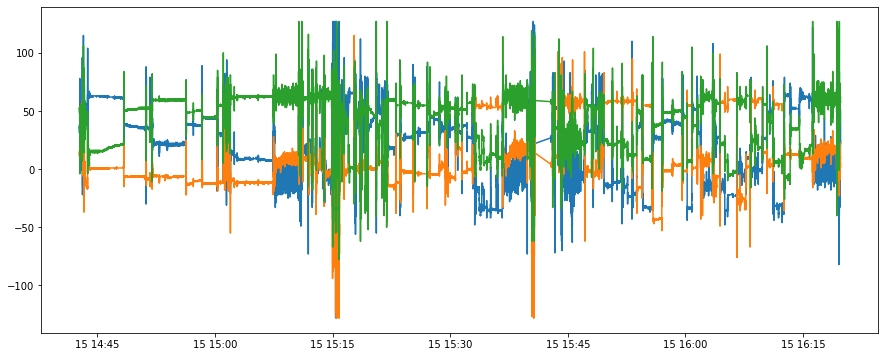

In [3]:
### Accelerometer ###

ACC_df = par.ACC_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(ACC_df["datetime"], ACC_df["accel_x"])
ax.plot(ACC_df["datetime"], ACC_df["accel_y"])
ax.plot(ACC_df["datetime"], ACC_df["accel_z"])

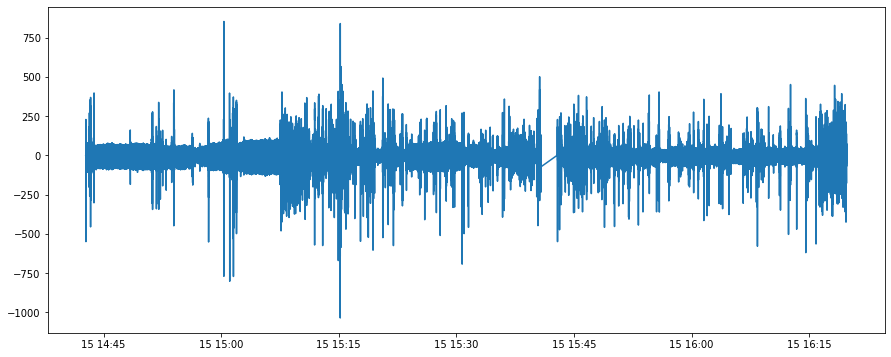

In [4]:
### Photoplethysmograph ###

BVP_df = par.BVP_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(BVP_df["datetime"], BVP_df["BVP"])

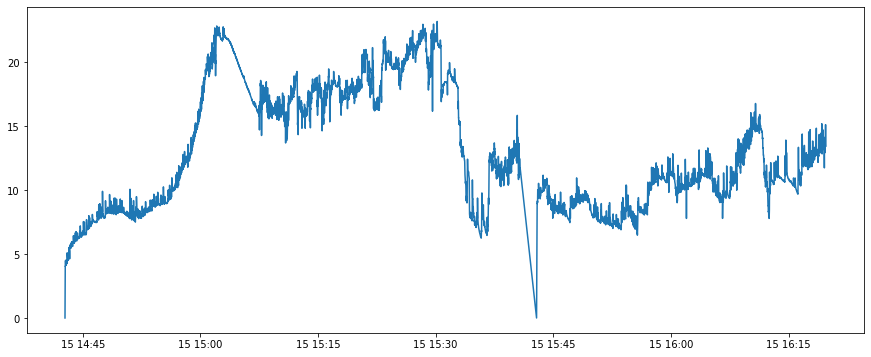

In [5]:
### Electrodermal ###

EDA_df = par.EDA_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(EDA_df["datetime"], EDA_df["EDA"])

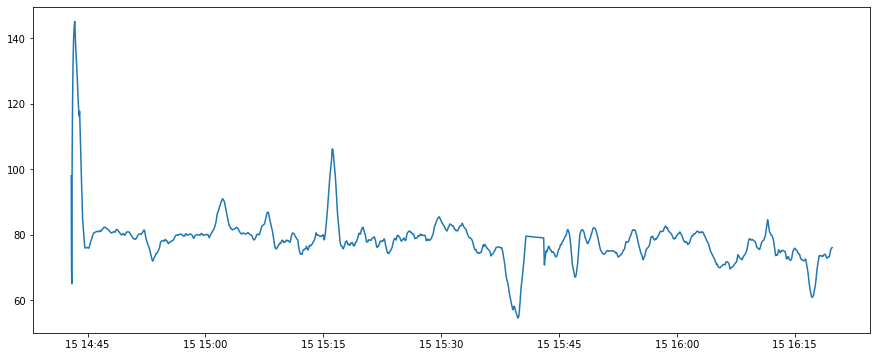

In [6]:
### Heart Rate ###

HR_df = par.HR_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(HR_df["datetime"], HR_df["HR"])

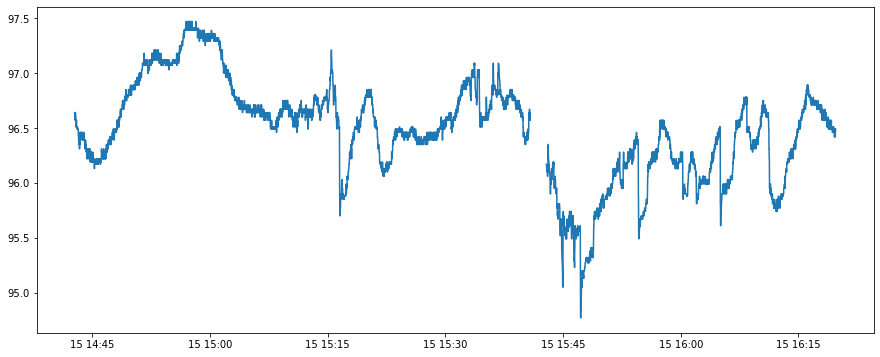

In [7]:
### Temperature ###

TEMP_df = par.TEMP_df

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(TEMP_df["datetime"], TEMP_df["temp_F"])